In [17]:
import functools
from dynesty import NestedSampler
from dynesty import utils as dyfunc
import numpy as np


def prior_transform(u):
    return u

def integrate_likelihood(x, *args, logp): #x = None, y = None
    if len(args) != 0 or type(x).__name__ == 'float': #and len(x) != 0:        
        X = np.array([x, *args])
        X = np.expand_dims(X, -2)
        output = np.exp(logp(X))[0]
    elif len(args) == 0: #and len([x]) != 0:
        x = np.array(x)
        #print(x)
        output = logp(x).squeeze(-1)
    else:
        print("Number of args: ", len(args))
        print("Args: ", args)
    return output

def dynesty_true_integral(bounds, ndim, dlogz, logp, prior_fac):
    ### Dynesty ###
    ptform_kwargs={'bounds': bounds}
    integrate_likelihood_dy = functools.partial(integrate_likelihood, logp=logp)
    sampler = NestedSampler(integrate_likelihood_dy, prior_transform, ndim=ndim, 
                       blob=False )#, pool=pool, queue_size=nthreads)
    sampler.run_nested(print_progress=True, dlogz=dlogz)
    
    res = sampler.results
    logz_dy = res.logz[-1] + 2*prior_fac #ln(z_dynesty) + ln(prior_fac) = z_dynesty*prior_fac = Evidence -> Why do we have to do 2xprior_fac?
    logzerr_dy = res.logzerr[-1]
    computed_integrals = dyfunc.compute_integrals(res.logl, res.logvol)
    #log.info(computed_integrals[1][-1], computed_integrals[2][-1])
    print(f"Logz from Dynesty = {logz_dy} +- {logzerr_dy} with {len(res.ncall)} samples")
    return logz_dy, logzerr_dy

In [18]:
ndim = 20
def gaussian(X):
    # X is a N x DIM shaped tensor, output is N tensor
    mean = np.array(0.5) #len(param_list)*
    sigma = np.array(0.1) #len(param_list)*
    return np.expand_dims((-0.5*np.sum((X-mean)**2/sigma**2, axis=-1, keepdims=False)), -1)
for i in range(1, ndim+1):
    dynesty_true_integral([0, 1]*i, i, 0.1, gaussian, 0)

1864it [00:00, 4173.21it/s, +500 | bound: 0 | nc: 1 | ncall: 19124 | eff(%): 12.693 | loglstar:   -inf < -0.000 <    inf | logz: -1.371 +/-  0.035 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -1.3708866394918453 +- 0.05545656046200535 with 2364 samples


2604it [00:00, 2652.87it/s, +500 | bound: 2 | nc: 1 | ncall: 20497 | eff(%): 15.522 | loglstar:   -inf < -0.000 <    inf | logz: -2.855 +/-  0.061 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -2.8550706100149665 +- 0.08022447191139682 with 3104 samples


3244it [00:00, 3249.04it/s, +500 | bound: 4 | nc: 1 | ncall: 21110 | eff(%): 18.166 | loglstar:   -inf < -0.001 <    inf | logz: -4.143 +/-  0.076 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -4.142816322628562 +- 0.09575490316988212 with 3744 samples


3868it [00:01, 2407.50it/s, +500 | bound: 6 | nc: 1 | ncall: 21874 | eff(%): 20.436 | loglstar:   -inf < -0.008 <    inf | logz: -5.410 +/-  0.088 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -5.4095911000880825 +- 0.10823398028096518 with 4368 samples


4603it [00:01, 3929.60it/s, +500 | bound: 8 | nc: 1 | ncall: 24891 | eff(%): 20.922 | loglstar:   -inf < -0.053 <    inf | logz: -6.929 +/-  0.101 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -6.928623462030359 +- 0.12269076968115641 with 5103 samples


5226it [00:01, 3323.92it/s, +500 | bound: 12 | nc: 1 | ncall: 25795 | eff(%): 22.637 | loglstar:   -inf < -0.081 <    inf | logz: -8.210 +/-  0.109 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -8.209677237614276 +- 0.13087705405773128 with 5726 samples


5825it [00:01, 3686.97it/s, +500 | bound: 15 | nc: 1 | ncall: 28057 | eff(%): 22.952 | loglstar:   -inf < -0.149 <    inf | logz: -9.480 +/-  0.118 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -9.480266005605415 +- 0.1406877690841465 with 6325 samples


6537it [00:01, 3596.42it/s, +500 | bound: 18 | nc: 1 | ncall: 30716 | eff(%): 23.289 | loglstar:   -inf < -0.268 <    inf | logz: -11.028 +/-  0.126 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -11.027968686689533 +- 0.1489875332083924 with 7037 samples


7244it [00:01, 3928.95it/s, +500 | bound: 23 | nc: 1 | ncall: 35640 | eff(%): 22.038 | loglstar:   -inf < -0.306 <    inf | logz: -12.485 +/-  0.134 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -12.484791622103604 +- 0.1548000106302515 with 7744 samples


7713it [00:04, 1916.11it/s, +500 | bound: 79 | nc: 1 | ncall: 196025 | eff(%):  4.200 | loglstar:   -inf < -0.681 <    inf | logz: -13.795 +/-  0.141 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -13.795261235664126 +- 0.16644977815872583 with 8213 samples


8344it [00:05, 1661.33it/s, +500 | bound: 88 | nc: 1 | ncall: 221377 | eff(%):  4.004 | loglstar:   -inf < -0.700 <    inf | logz: -15.080 +/-  0.148 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -15.08021159488974 +- 0.17157418644928996 with 8844 samples


9162it [00:08, 1049.68it/s, +500 | bound: 99 | nc: 1 | ncall: 254157 | eff(%):  3.809 | loglstar:   -inf < -0.593 <    inf | logz: -16.617 +/-  0.153 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -16.617409914774143 +- 0.1738960325090856 with 9662 samples


9733it [00:09, 974.95it/s, +500 | bound: 106 | nc: 1 | ncall: 280479 | eff(%):  3.655 | loglstar:   -inf < -0.899 <    inf | logz: -18.064 +/-  0.160 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -18.063630393385523 +- 0.1819871380138267 with 10233 samples


10225it [00:10, 963.61it/s, +500 | bound: 113 | nc: 1 | ncall: 304988 | eff(%):  3.522 | loglstar:   -inf < -1.254 <    inf | logz: -19.399 +/-  0.167 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -19.399126204437163 +- 0.19266174207886316 with 10725 samples


10552it [00:10, 996.40it/s, +500 | bound: 120 | nc: 1 | ncall: 327843 | eff(%):  3.376 | loglstar:   -inf < -1.591 <    inf | logz: -20.392 +/-  0.170 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -20.391789270352106 +- 0.1959094148316319 with 11052 samples


11322it [00:09, 1153.14it/s, +500 | bound: 128 | nc: 1 | ncall: 362783 | eff(%):  3.263 | loglstar:   -inf < -1.694 <    inf | logz: -22.037 +/-  0.175 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -22.037205747165466 +- 0.20010796474233683 with 11822 samples


11717it [00:08, 1387.42it/s, +500 | bound: 134 | nc: 1 | ncall: 386198 | eff(%):  3.168 | loglstar:   -inf < -2.010 <    inf | logz: -23.139 +/-  0.181 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -23.139012845496982 +- 0.2084387276629708 with 12217 samples


12581it [00:17, 739.76it/s, +500 | bound: 145 | nc: 1 | ncall: 428980 | eff(%):  3.053 | loglstar:   -inf < -1.969 <    inf | logz: -24.830 +/-  0.186 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -24.830454410651445 +- 0.20910014985027278 with 13081 samples


13136it [00:17, 757.18it/s, +500 | bound: 155 | nc: 1 | ncall: 462709 | eff(%):  2.950 | loglstar:   -inf < -1.931 <    inf | logz: -25.906 +/-  0.189 | dlogz:  0.000 >  0.100]


Logz from Dynesty = -25.90581933105918 +- 0.20941786231574583 with 13636 samples


13672it [00:17, 775.41it/s, +500 | bound: 162 | nc: 1 | ncall: 493977 | eff(%):  2.872 | loglstar:   -inf < -2.558 <    inf | logz: -27.600 +/-  0.196 | dlogz:  0.000 >  0.100]

Logz from Dynesty = -27.59976663847206 +- 0.2197643581758141 with 14172 samples


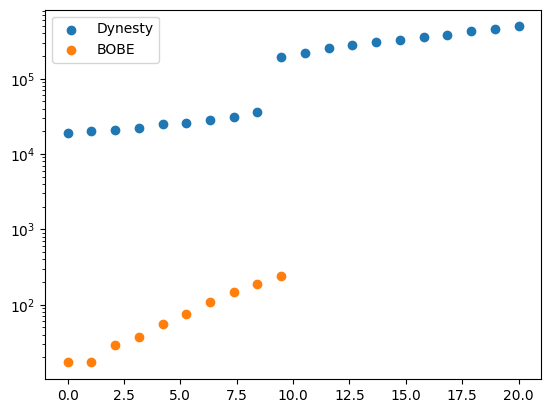

In [19]:
import matplotlib.pyplot as plt

DySamples = [19124, 20497, 21110, 21874, 24891, 25795, 28057, 30716, 35640, 196025, 221377, 254157, 280479, 304988, 327843, 362783, 386198, 428980, 462709, 493977]
BOBESamples = [17, 17, 28.667, 36.667, 55, 75.333, 107.667, 144.667, 187.333, 243, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
x = np.linspace(0, 20, 20)

plt.plot()
plt.scatter(x, DySamples, label="Dynesty")
plt.scatter(x, BOBESamples, label="BOBE")
plt.yscale('log')
plt.legend()
plt.show()